# Impulse Response Experiments

Modal parameter identification for a structural system given its impulse response.

The system is assumed to be linear time-invariant, and the responses are measured in discrete time.

## Problem Statement

Given:

- Observed response $y_{k} = y(k\Delta t)$
- Impulse input $u_{k} = \ddot{u}_g(k\Delta t)$
    - a unit of input acceleration at time zero; zero input acceleration at all other times.

![impulse response plot](./figures/impulse.png)

Unknown:

- System state $x_{k} = x(k\Delta t)$
- Coefficients $A,B,C,D$ for the state space representation:
$$x_{k+1} = Ax_{k} + Bu_{k}$$
$$y_{k} = Cx_{k} + Du_{k},$$

Goal: identify $A,B,C,D$ which produce the given impulse response. Then,

1. Generate a response prediction (sanity check):
    - $y_{k}$
2. Estimate the system's modal properties:
    - Natural frequencies $\omega_{n}$
    - Modal damping ratios $\zeta_{n}$
    - Mode shapes $\phi_{n}$.

In [1]:
import numpy as np
from mdof import realize, modal
from control.matlab import ss
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from matplotlib import pyplot as plt
import scipy.integrate
import sdof
from collections import defaultdict
sys = defaultdict(dict) # somewhere to store each experiment's data


## Impulse Response Experiment 1: Single Column, Different Directions

![impulse experiment 1 input output](./figures/impulse_exp_IO1.png)

### Matrix Representation

The input is represented by:
$$u_{0} =   \begin{bmatrix}
                    1       & 0         & \cdots    & 0         \\
                    0       & 1         & \cdots    & 0         \\
                    \vdots  & \vdots    & \ddots    & \vdots    \\
                    0       & 0         & \cdots    & 1
            \end{bmatrix} _{q \times q}  = \mathbb{I}_{q \times q},
~~~~~ u_{k \neq 0} =   \begin{bmatrix}
                    0       & 0         & \cdots    & 0         \\
                    0       & 0         & \cdots    & 0         \\
                    \vdots  & \vdots    & \ddots    & \vdots    \\
                    0       & 0         & \cdots    & 0
            \end{bmatrix} _{q \times q}  = \mathbb{0}_{q \times q}.$$

The output is represented by:
$$y_{k} =       \begin{bmatrix} y_{k1} & y_{k2} & \cdots  & y_{kq}
                \end{bmatrix} _{p \times q},$$
where the $i^{th}$ column $y_{ki}$ corresponds to the response to an impulse at the $i^{th}$ input node.

$q$ is the number of inputs, and $p$ is the number of outputs. For this example, $q = 2$ and $p = 2$, so 
$$u_{0} =   \begin{bmatrix}
                    1       & 0   \\
                    0       & 1  
            \end{bmatrix} = \mathbb{I}_{2 \times 2},
~~~~~ u_{k \neq 0} =   \begin{bmatrix}
                    0       & 0   \\
                    0       & 0   
            \end{bmatrix}  = \mathbb{0}_{2 \times 2},
~~~~~ y_{k} =   \begin{bmatrix}
                    y_{k11} & y_{k12} \\
                    y_{k21} & y_{k22}
                \end{bmatrix} .$$

### Parameters and Dimensions

Parameter | Value
----------|-------
`p ` | Number of output channels (number of nodes at which response is observed)
`q ` | Number of input channels (number of support nodes where ground acceleration is applied)
`n ` | State dimension (2 $\times$ the number of structural nodes)
`r ` | Model order (2 $\times$ the degrees of freedom for the identified system. Can be different from state dimension; for model reduction, is lower than state dimension.)
`nt` | number of timesteps
`dt` | timestep

Full state space representation

Coefficient | Dimensions
------------|------------
$\mathbf{A}$ | $n \times n$
$\mathbf{B}$ | $n \times q$
$\mathbf{C}$ | $p \times n$
$\mathbf{D}$ | $p \times q$

Identified state space representation

Coefficient | Dimensions
------------|------------
$\mathbf{\tilde{A}}$ | $r \times r$
$\mathbf{\tilde{B}}$ | $r \times q$
$\mathbf{\tilde{C}}$ | $p \times r$
$\mathbf{\tilde{D}}$ | $p \times q$

In [2]:
# Load impulse response data
exp = "changedof"  # Single column, different directions
q = 2
p = 2
input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
nt = len(input11)
dt = 0.1
times = np.arange(start=0,stop=dt*nt,step=dt)

sys[exp]["input"] = np.empty((q,q,nt))
sys[exp]["output"] = np.empty((p,q,nt))
for i in range(q):
    for j in range(q):
        sys[exp]["input"][j,i,:] = np.loadtxt(f"./hwd_ops_impulse/{exp}/u{j+1}_u{i+1}.txt")  # "response" at input channel j+1 from impulse at input channel i+1
    for j in range(p):
        sys[exp]["output"][j,i,:] = np.loadtxt(f"./hwd_ops_impulse/{exp}/y{j+1}_u{i+1}.txt") # response at output channel j+1 from impulse at input channel i+1

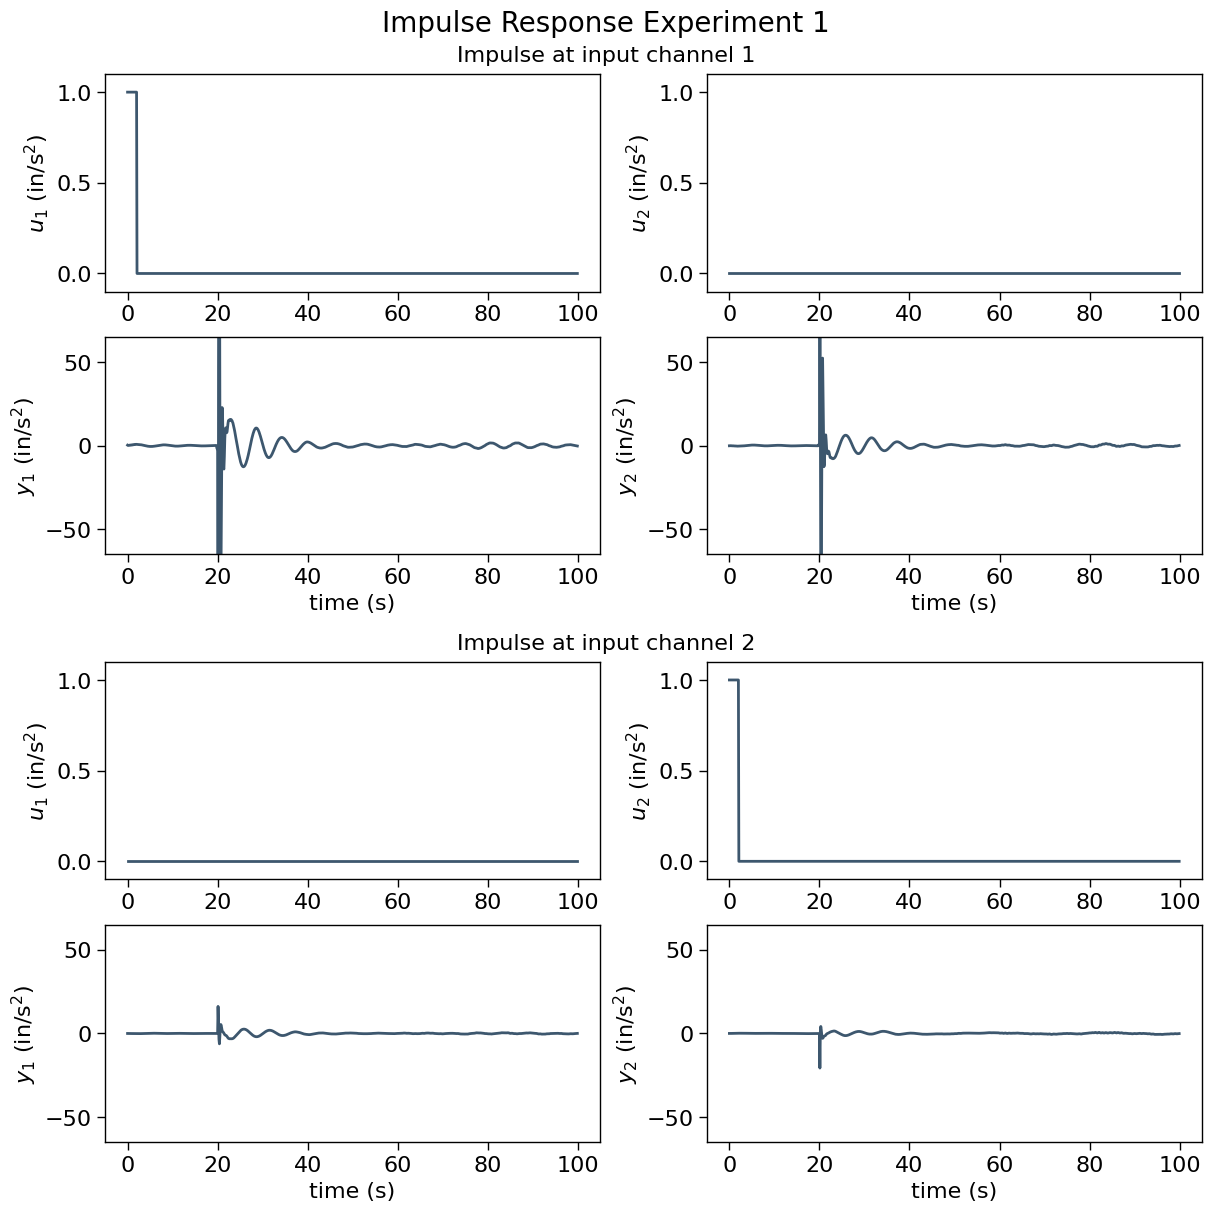

In [3]:
# Plot impulse response data
exp = "changedof"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 1', fontsize=20)
subfigs = fig.subfigures(2,1)
for i in range(q):
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].plot(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].plot(times, sys[exp]["output"][j,i])
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-65,65))
        axes[1,j].set_xlabel("time (s)", fontsize=16)

In [4]:
# Identify a state space representation using ERA
exp = "changedof"
r = 50
nco = int(np.floor((nt-1)/2))
sys[exp]["ERA"] = dict()
sys[exp]["ERA"]["ABCD"] = realize.era(Y=sys[exp]["output"], no=nco, nc=nco, r=r) # A,B,C,D
sys[exp]["ERA"]['ss'] = ss(*sys[exp]["ERA"]["ABCD"],dt) # state-space object

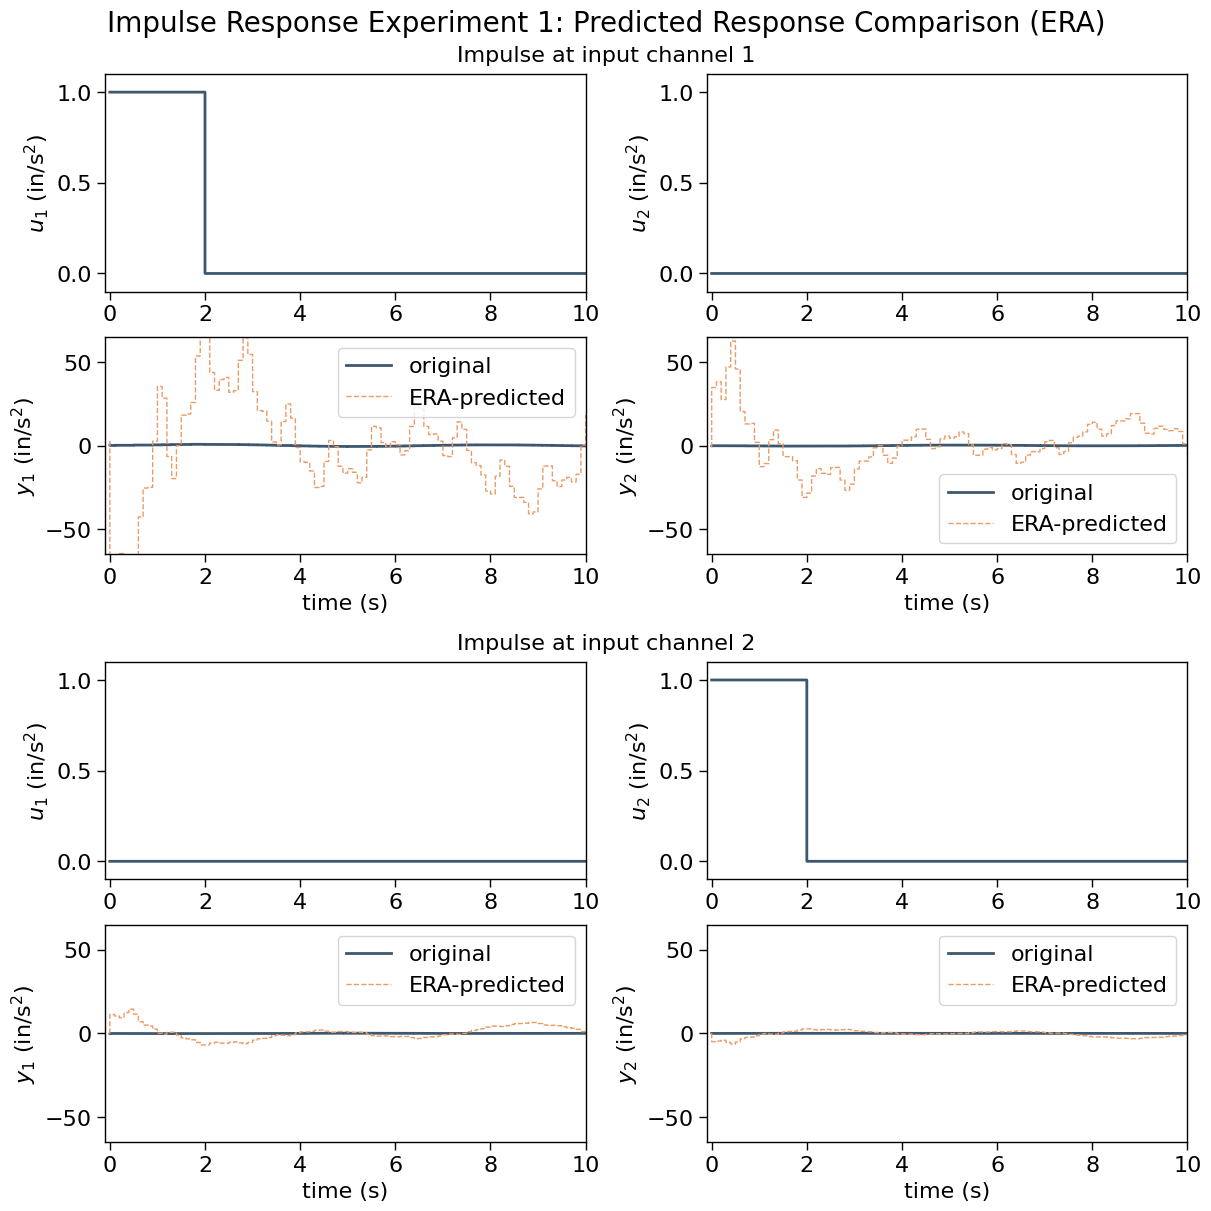

In [6]:
# Plot predicted response using the ERA-identified state space representation
exp = "changedof"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 1: Predicted Response Comparison (ERA)', fontsize=20)
subfigs = fig.subfigures(2,1)
sys[exp]["ERA"]["ypred"] = np.empty((p,q,nt))
for i in range(q):
    sys[exp]["ERA"]["ypred"][:,i,:] = impulse(sys[exp]["ERA"]['ss'],times,input=i)[0].T*dt # Need to investigate why the generated impulse needs to be multiplied by dt.
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].step(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].step(times, sys[exp]["output"][j,i], label="original")
        axes[1,j].step(times, sys[exp]["ERA"]["ypred"][j,i], "--", label="ERA-predicted", linewidth=1)
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-65,65))
        axes[1,j].set_xlabel("time (s)", fontsize=16)
        axes[1,j].legend()
    for axi in axes:
        for axj in axi:
            axj.set_xlim(-0.1,10)

In [7]:
# Estimate modal parameters (ERA)
exp = "changedof"
sys[exp]["ERA"]["modes"] = modes.modes(sys[exp]["ERA"]["ABCD"],dt)
periods = [1/f for f in sorted([sys[exp]["ERA"]["modes"][str(i)]['freq'] for i in list(sys[exp]["ERA"]["modes"].keys())])]
sys[exp]["ERA"]["periods"] = periods
print('Periods:', periods)
# for i in list(sys[exp]["ERA"]["modes"].keys()):
#     print("Mode:", str(i))
#     print("Condition Number:", sys[exp]["ERA"]["modes"][str(i)]['cnd'])
#     print("Period:", 1/sys[exp]["ERA"]["modes"][str(i)]['freq'])
#     print("Damping Ratio:", sys[exp]["ERA"]["modes"][str(i)]['damp'])
#     print("Mode Shape:", sys[exp]["ERA"]["modes"][str(i)]['modeshape'])

Periods: [1.277769337331387, 1.0834839447714717, 1.0001692614261624, 0.9073502317028733, 0.6782290706905041, 0.5702526760456692, 0.4744410267678063, 0.41350638991320526, 0.3813248130214179, 0.3712024541076242, 0.36464033998679424, 0.3539191347124598, 0.34803289115696123, 0.3388832578233755, 0.303557472687965, 0.2898361257508265, 0.23728865341519823, 0.22656302496307693, 0.22032820480556778, 0.21417739869536567, 0.21260904690858176, 0.21030385952422398, 0.20624388765180673, 0.20554834615554132]


/mnt/c/Users/16507/Documents/GitHub/SystemIdentification/src/mdof/modes.py:36: RuntimeWarning: invalid value encountered in true_divide
  damp = -np.real(Lam)/Omega


In [8]:
# Identify a state space representation using ERA-DC
exp = "changedof"
r = 50
sys[exp]["ERA-DC"] = dict()
sys[exp]["ERA-DC"]["ABCD"] = realize.era_dc(Y=sys[exp]["output"],r=r)
sys[exp]["ERA-DC"]['ss'] = ss(*sys[exp]["ERA-DC"]["ABCD"],dt)

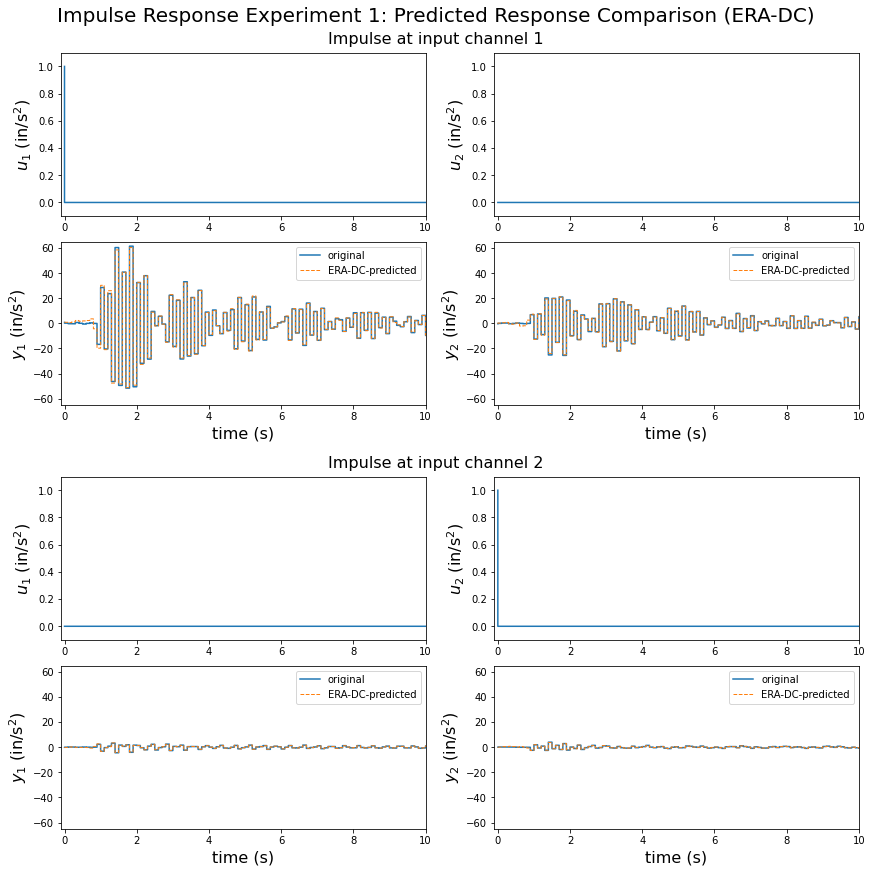

In [9]:
# Plot predicted response using the ERA-DC-identified state space representation
exp = "changedof"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 1: Predicted Response Comparison (ERA-DC)', fontsize=20)
subfigs = fig.subfigures(2,1)
sys[exp]["ERA-DC"]["ypred"] = np.empty((p,q,nt))
for i in range(q):
    sys[exp]["ERA-DC"]["ypred"][:,i,:] = impulse(sys[exp]["ERA-DC"]['ss'],times,input=i)[0].T*dt # Need to investigate why the generated impulse needs to be multiplied by dt.
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].step(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].step(times, sys[exp]["output"][j,i], label="original")
        axes[1,j].step(times, sys[exp]["ERA-DC"]["ypred"][j,i], "--", label="ERA-DC-predicted", linewidth=1)
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-65,65))
        axes[1,j].set_xlabel("time (s)", fontsize=16)
        axes[1,j].legend()
    for axi in axes:
        for axj in axi:
            axj.set_xlim(-0.1,10)

In [10]:
# Estimate modal parameters (ERA-DC)
exp = "changedof"
sys[exp]["ERA-DC"]["modes"] = modes.modes(sys[exp]["ERA-DC"]["ABCD"],dt)
periods = [1/f for f in sorted([sys[exp]["ERA-DC"]["modes"][str(i)]['freq'] for i in list(sys[exp]["ERA-DC"]["modes"].keys())])]
sys[exp]["ERA-DC"]["periods"] = periods
print('Periods:', periods)

Periods: [1.277890140515925, 1.083507177943179, 0.9995895391175651, 0.9065616163516015, 0.6358542122015609, 0.6305565422025324, 0.47466032306153944, 0.38698587369129256, 0.3813197820372518, 0.3711273981534202, 0.36460562848680306, 0.35377532950853885, 0.3486807888545456, 0.33892580589897187, 0.2900801889049035, 0.2828631126265185, 0.2291821391568256, 0.22567918558171438, 0.22059569904589027, 0.21477135833302602, 0.21256835190216647, 0.2104178958964766, 0.20871612233488002, 0.2062285570247892]


## Impulse Response Experiment 2: 2 Columns, Same Direction

![impulse experiment 2 input output](./figures/impulse_exp_IO2.png)

In [11]:
# Load impulse response data
exp = "changecol"  # 2 columns, same direction
q = 2
p = 2
input11  = np.loadtxt("./hwd_ops_impulse/"+exp+"/u1_u1.txt")
nt = len(input11)
dt = 0.1
times = np.arange(start=0,stop=dt*nt,step=dt)

sys[exp]["input"] = np.empty((q,q,nt))
sys[exp]["output"] = np.empty((p,q,nt))
for i in range(q):
    for j in range(q):
        sys[exp]["input"][j,i,:] = np.loadtxt(f"./hwd_ops_impulse/{exp}/u{j+1}_u{i+1}.txt")  # "response" at input channel j+1 from impulse at input channel i+1
    for j in range(p):
        sys[exp]["output"][j,i,:] = np.loadtxt(f"./hwd_ops_impulse/{exp}/y{j+1}_u{i+1}.txt") # response at output channel j+1 from impulse at input channel i+1

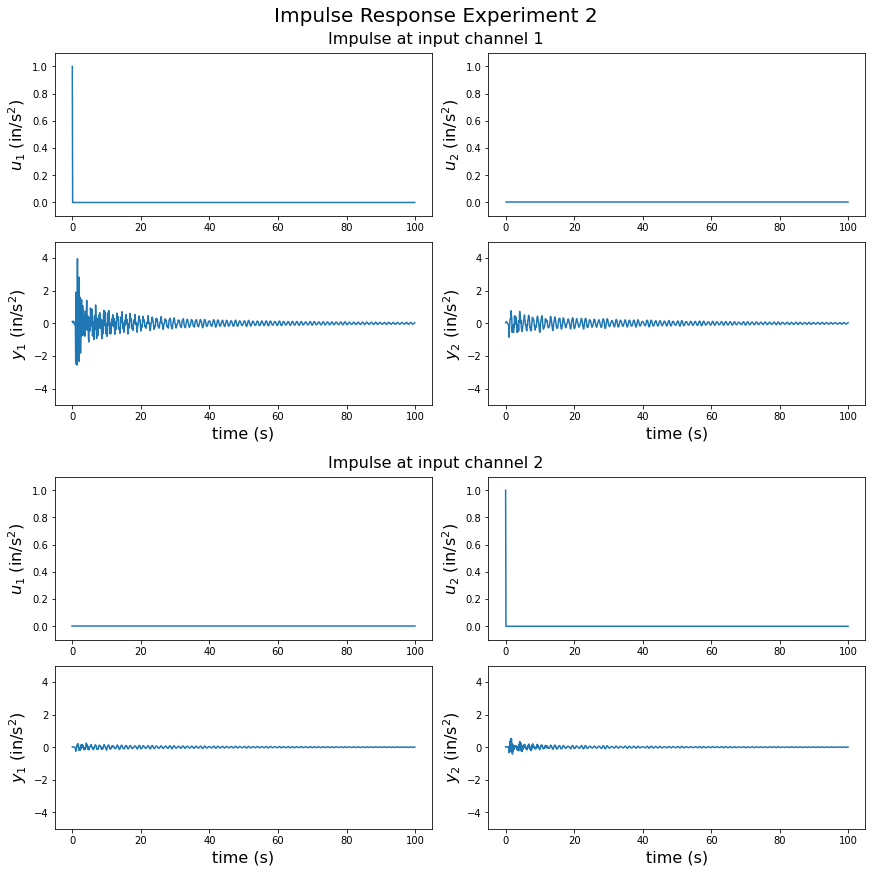

In [12]:
# Plot impulse response data
exp = "changecol"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 2', fontsize=20)
subfigs = fig.subfigures(2,1)
for i in range(q):
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].plot(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].plot(times, sys[exp]["output"][j,i])
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-5,5))
        axes[1,j].set_xlabel("time (s)", fontsize=16)

In [13]:
# Identify a state space representation using ERA
exp = "changecol"
r = 50
nco = int(np.floor((nt-1)/2))
sys[exp]["ERA"] = dict()
sys[exp]["ERA"]["ABCD"] = realize.era(Y=sys[exp]["output"], no=nco, nc=nco, r=r) # A,B,C,D
sys[exp]["ERA"]['ss'] = ss(*sys[exp]["ERA"]["ABCD"],dt) # state-space object

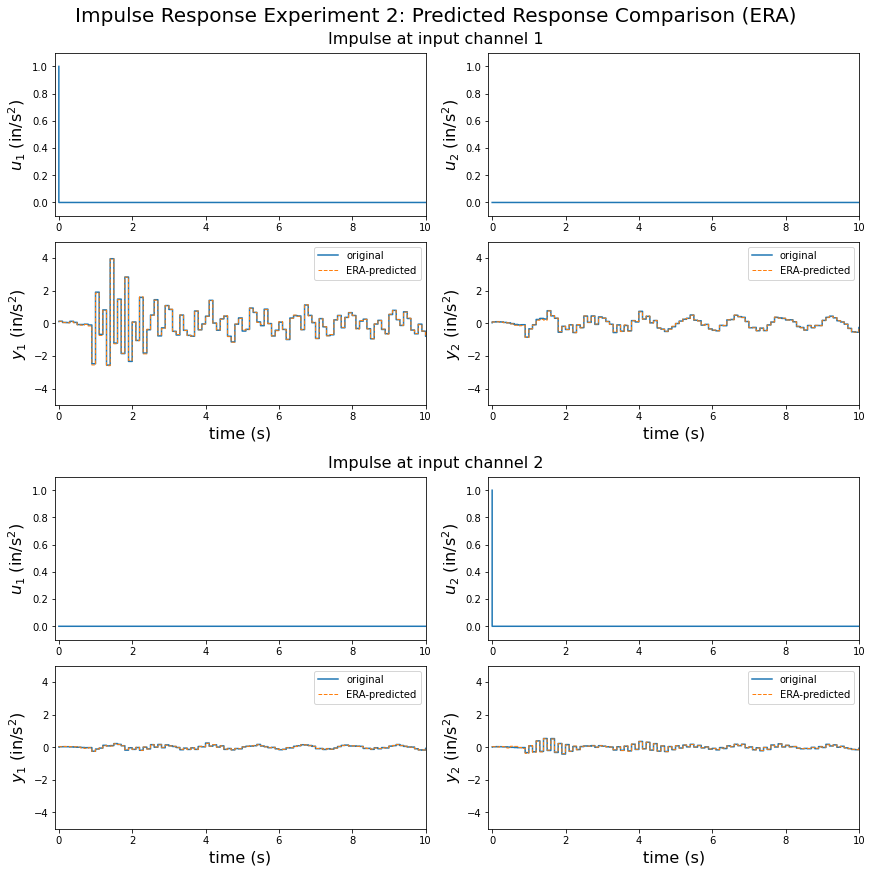

In [14]:
# Plot predicted response using the ERA-identified state space representation
exp = "changecol"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 2: Predicted Response Comparison (ERA)', fontsize=20)
subfigs = fig.subfigures(2,1)
sys[exp]["ERA"]["ypred"] = np.empty((p,q,nt))
for i in range(q):
    sys[exp]["ERA"]["ypred"][:,i,:] = impulse(sys[exp]["ERA"]['ss'],times,input=i)[0].T*dt # Need to investigate why the generated impulse needs to be multiplied by dt.
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].step(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].step(times, sys[exp]["output"][j,i], label="original")
        axes[1,j].step(times, sys[exp]["ERA"]["ypred"][j,i], "--", label="ERA-predicted", linewidth=1)
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-5,5))
        axes[1,j].set_xlabel("time (s)", fontsize=16)
        axes[1,j].legend()
    for axi in axes:
        for axj in axi:
            axj.set_xlim(-0.1,10)

In [15]:
# Estimate modal parameters (ERA)
exp = "changecol"
sys[exp]["ERA"]["modes"] = modes.modes(sys[exp]["ERA"]["ABCD"],dt)
periods = [1/f for f in sorted([sys[exp]["ERA"]["modes"][str(i)]['freq'] for i in list(sys[exp]["ERA"]["modes"].keys())])]
sys[exp]["ERA"]["periods"] = periods
print('Periods:', periods)
# for i in list(sys[exp]["ERA"]["modes"].keys()):
#     print("Mode:", str(i))
#     print("Condition Number:", sys[exp]["ERA"]["modes"][str(i)]['cnd'])
#     print("Period:", 1/sys[exp]["ERA"]["modes"][str(i)]['freq'])
#     print("Damping Ratio:", sys[exp]["ERA"]["modes"][str(i)]['damp'])
#     print("Mode Shape:", sys[exp]["ERA"]["modes"][str(i)]['modeshape'])

Periods: [1.277746435967083, 1.0826140687951809, 1.0007921339182788, 0.907745917624456, 0.9049128839384317, 0.5004401017510929, 0.4951162841231206, 0.4746947221783039, 0.4292480115730964, 0.38133607463447705, 0.371288733698002, 0.36453534778299107, 0.35349626948279234, 0.31514176474926997, 0.25366037668520486, 0.24508719294522993, 0.2291067536065316, 0.2216404368756368, 0.21938096594934212, 0.2149323097447933, 0.2123729858896509, 0.2104323086284169, 0.206216078283043, 0.2035929182694195, 0.20238247267343695]


In [16]:
# Identify a state space representation using ERA-DC
exp = "changecol"
r = 50
sys[exp]["ERA-DC"] = dict()
sys[exp]["ERA-DC"]["ABCD"] = realize.era_dc(Y=sys[exp]["output"],r=r)
sys[exp]["ERA-DC"]['ss'] = ss(*sys[exp]["ERA-DC"]["ABCD"],dt)

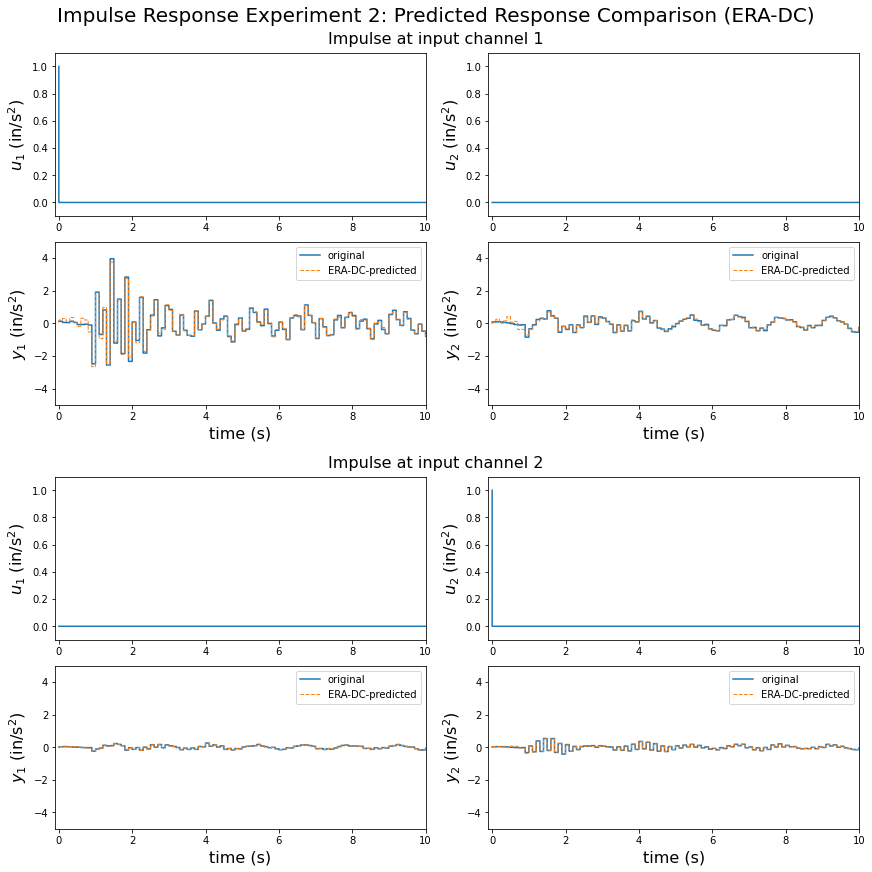

In [17]:
# Plot predicted response using the ERA-DC-identified state space representation
exp = "changecol"
fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('Impulse Response Experiment 2: Predicted Response Comparison (ERA-DC)', fontsize=20)
subfigs = fig.subfigures(2,1)
sys[exp]["ERA-DC"]["ypred"] = np.empty((p,q,nt))
for i in range(q):
    sys[exp]["ERA-DC"]["ypred"][:,i,:] = impulse(sys[exp]["ERA-DC"]['ss'],times,input=i)[0].T*dt # Need to investigate why the generated impulse needs to be multiplied by dt.
    subfigs[i].suptitle(f"Impulse at input channel {i+1}", fontsize=16)
    axes = subfigs[i].subplots(p,q)
    for j in range(q):
        axes[0,j].step(times, sys[exp]["input"][j,i])
        axes[0,j].set_ylabel(rf"$u_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[0,j].set_ylim((-0.1,1.1))
    for j in range(p):
        axes[1,j].step(times, sys[exp]["output"][j,i], label="original")
        axes[1,j].step(times, sys[exp]["ERA-DC"]["ypred"][j,i], "--", label="ERA-DC-predicted", linewidth=1)
        axes[1,j].set_ylabel(rf"$y_{j+1}$ (in/s$^{2}$)", fontsize=16)
        axes[1,j].set_ylim((-5,5))
        axes[1,j].set_xlabel("time (s)", fontsize=16)
        axes[1,j].legend()
    for axi in axes:
        for axj in axi:
            axj.set_xlim(-0.1,10)

In [18]:
# Estimate modal parameters (ERA-DC)
exp = "changecol"
sys[exp]["ERA-DC"]["modes"] = modes.modes(sys[exp]["ERA-DC"]["ABCD"],dt)
periods = [1/f for f in sorted([sys[exp]["ERA-DC"]["modes"][str(i)]['freq'] for i in list(sys[exp]["ERA-DC"]["modes"].keys())])]
sys[exp]["ERA-DC"]["periods"] = periods
print('Periods:', periods)

Periods: [1.2777592424838236, 1.0826182532314703, 1.0004874578173049, 0.9350696363248269, 0.9076748103553772, 0.500620295654151, 0.49499135233877956, 0.4746414239394774, 0.43690264948064866, 0.38134019047275003, 0.37135248977671376, 0.3645743275628258, 0.3534291552125862, 0.3171632836208534, 0.2452258911836472, 0.2404198626348075, 0.2285308581972355, 0.2212914995140883, 0.21949796212281478, 0.21479236752335398, 0.21235240562942564, 0.21010489523056702, 0.20641036121758427, 0.2028022332710203]


## Compare estimated periods from each impulse response experiment

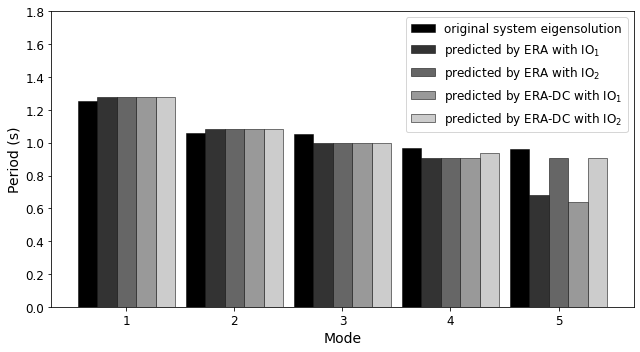

In [19]:
nModes = 5
true_periods = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:nModes]

fig, ax = plt.subplots(figsize=(9,5), tight_layout=True)
ind = np.arange(nModes)
width = 0.9/nModes
ax.bar(ind-2*width, true_periods, width, label="original system eigensolution", color=(0/nModes,0/nModes,0/nModes), edgecolor="k", linewidth=0.5)
ax.bar(ind-width, sys['changedof']["ERA"]["periods"][:nModes], width, label=r"predicted by ERA with IO$_{1}$", color=(1/nModes,1/nModes,1/nModes), edgecolor="k", linewidth=0.5)
ax.bar(ind, sys['changecol']["ERA"]["periods"][:nModes], width, label=r"predicted by ERA with IO$_{2}$", color=(2/nModes,2/nModes,2/nModes), edgecolor="k", linewidth=0.5)
ax.bar(ind+width, sys['changedof']["ERA-DC"]["periods"][:nModes], width, label=r"predicted by ERA-DC with IO$_{1}$", color=(3/nModes,3/nModes,3/nModes), edgecolor="k", linewidth=0.5)
ax.bar(ind+2*width, sys['changecol']["ERA-DC"]["periods"][:nModes], width, label=r"predicted by ERA-DC with IO$_{2}$", color=(4/nModes,4/nModes,4/nModes), edgecolor="k", linewidth=0.5)
ax.set_xticks(np.arange(nModes))
ax.set_xticklabels(np.arange(1,nModes+1))
ax.set_ylim((0,1.8))
ax.set_xlabel('Mode', fontsize=14)
ax.set_ylabel('Period (s)', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12);

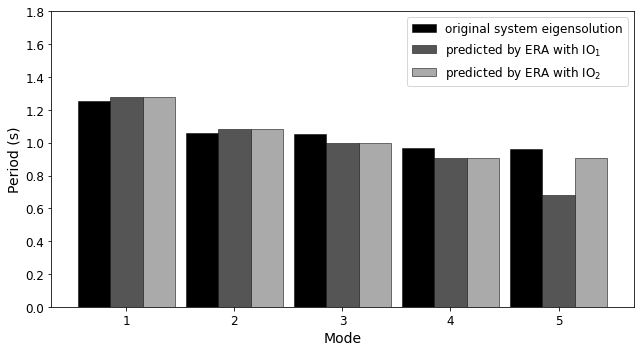

In [28]:
nMethods = 3
nModes = 5
true_periods = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:nModes]

fig, ax = plt.subplots(figsize=(9,5), tight_layout=True)
ind = np.arange(nModes)
width = 0.9/nMethods
ax.bar(ind-width, true_periods, width, label="original system eigensolution", color=(0/nMethods,0/nMethods,0/nMethods), edgecolor="k", linewidth=0.5)
ax.bar(ind, sys['changedof']["ERA"]["periods"][:nModes], width, label=r"predicted by ERA with IO$_{1}$", color=(1/nMethods,1/nMethods,1/nMethods), edgecolor="k", linewidth=0.5)
ax.bar(ind+width, sys['changecol']["ERA"]["periods"][:nModes], width, label=r"predicted by ERA with IO$_{2}$", color=(2/nMethods,2/nMethods,2/nMethods), edgecolor="k", linewidth=0.5)
# ax.bar(ind+width, sys['changedof']["ERA-DC"]["periods"][:nModes], width, label=r"predicted by ERA-DC with IO$_{1}$", color=(3/nModes,3/nModes,3/nModes), edgecolor="k", linewidth=0.5)
# ax.bar(ind+2*width, sys['changecol']["ERA-DC"]["periods"][:nModes], width, label=r"predicted by ERA-DC with IO$_{2}$", color=(4/nModes,4/nModes,4/nModes), edgecolor="k", linewidth=0.5)
ax.set_xticks(np.arange(nModes))
ax.set_xticklabels(np.arange(1,nModes+1))
ax.set_ylim((0,1.8))
ax.set_xlabel('Mode', fontsize=14)
ax.set_ylabel('Period (s)', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12);

## Juang Experiment

**System: 5 dof**

Modal properties (modal contributions and initial amplitudes are the same for each mode)

Mode | Frequency (Hz) | Damping Ratio (% of critical)
---- | -------------- | -----------------------------
1 | 0.159 | 1
2 | 0.318 | 1
3 | 0.477 | 1
4 | 0.636 | 1
5 | 0.795 | 1

**Data**

30 responses of 512 timesteps at 0.4s generated with 2% noise (RMS signal/noise)

**Results**

Mean damping ratio from ERA and ERA/DC - derived state space coefficients

In [21]:
frequencies = [0.159, 0.318, 0.477, 0.636, 0.795]
omegas = 2*np.pi*np.array(frequencies) # rad/s
zeta = 0.01
omegaDs = np.sqrt(1-zeta**2)*omegas
nt = 512
dt = 0.4

M = np.eye(5)
C = 2*zeta*np.diag(omegas)
K = np.diag(omegas**2)

Ac = np.array(np.vstack((np.hstack((np.zeros(K.shape), np.eye(5))), np.hstack(([-K, -C])))))
Ad = scipy.linalg.expm(dt*Ac)
Bc = np.array([np.zeros(5), -np.ones(5)]).reshape((10,1))
def integrand(t):
    return scipy.linalg.expm(t*Ac) @ Bc
Bd, err = scipy.integrate.quad_vec(integrand,0,dt)
Cd = np.array(np.hstack([-K, -C]))
Dd = np.array(-np.ones(5)).reshape(5,1)

# import pandas as pd
# pd.DataFrame(Ac)
# plt.spy(Ac);
# plt.spy(Cd);
# print(Cd)
print(Bd)

[[-0.07873174]
 [-0.07543323]
 [-0.07031731]
 [-0.06370444]
 [-0.05599567]
 [-0.38788668]
 [-0.35590403]
 [-0.30714495]
 [-0.24619417]
 [-0.17861133]]


1.0 0.019980529276831086 0.9980538754557603
1.0 0.03996105855366217 3.992215501823041
1.0 0.05994158783049325 8.98248487910184
1.0 0.07992211710732434 15.968862007292165
1.0 0.09990264638415543 24.951346886394006


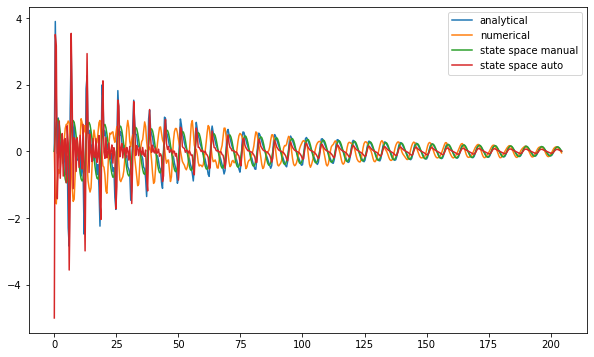

In [22]:
t = np.arange(start=0, stop=nt*dt, step=dt)

# Analytical Solution
# y_ana = np.array([-(np.exp(-omega*zeta*t))/omegaD * (np.sin(omegaD*t)) for omega,omegaD in zip(omegas,omegaDs)])
y_ana = np.array([(np.exp(-omega*zeta*t)) * (np.sin(omegaD*t)) for omega,omegaD in zip(omegas,omegaDs)])
Y_ana = np.array(y_ana).sum(axis=0)

# Numerical Integration
y_num = []
for i in range(5):
    print(M[i,i],C[i,i],K[i,i])
    u,v,a = sdof.integrate(M[i,i],C[i,i],K[i,i], np.zeros(nt), dt, v0=-1)
    y_num.append(u)
Y_num = np.array(y_num).sum(axis=0)

# Manually form impulse response from discrete state space model
x0 = np.array(np.hstack((np.zeros(5),1/omegas**2)))
xs = np.zeros((10,nt))
xs[:,0] = x0
for j in range(1,nt):
    xs[:,j] = Ad@xs[:,j-1]
y_ssm = xs[:5,:]
Y_ssm = np.array(y_ssm).sum(axis=0)

# Automatically form impulse response from discrete state space model using control.matlab package
sysJuang = ss(Ad,Bd,Cd,Dd,dt)
Y_ssa=impulse(sysJuang,t)[0]*dt
Y_ssa = Y_ssa.sum(axis=1)

# Plot to compare
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t,Y_ana,label="analytical")
ax.plot(t,Y_num,label="numerical")
ax.plot(t,Y_ssm,label="state space manual")
ax.plot(t,Y_ssa,label="state space auto")
ax.legend();

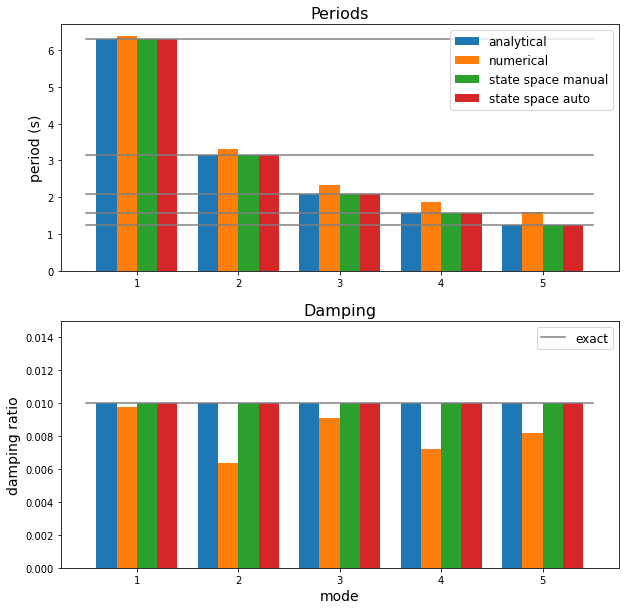

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for f in frequencies:
    ax[0].plot([-0.2,4.8],[1/f,1/f], color="gray")
ax[1].plot([-0.2,4.8],[0.01,0.01], color="gray", label="exact")

labels = ["analytical", "numerical", "state space manual", "state space auto"]
thickness = [2, 2, 2, 2]
linetypes = ["-", "-", ":", "-"]

for i,y in enumerate([Y_ana, Y_num, Y_ssm, Y_ssa]):
    y = y[None,None,:]
    A,B,C,D = realize.era_dc(Y=y,r=10)
    mode_dict = modes.modes([A,B,C,D],dt)
    periods = [1/f for f in sorted([mode_dict[i]['freq'] for i in mode_dict.keys()])]
    width=0.2
    ax[0].bar(np.arange(5)+i*width, periods, width=width, label=labels[i])
    # ax[0].plot(periods, linewidth=thickness[i], linestyle=linetypes[i], label=labels[i])
    damping = [d for d in [mode_dict[i]['damp'] for i in mode_dict.keys()]]
    ax[1].bar(np.arange(5)+i*width, damping, width=width)
    # ax[1].plot(damping, linewidth=thickness[i], linestyle=linetypes[i], label=labels[i])
    ax[0].set_xticks(np.arange(nModes)+1.5*width)
    ax[0].set_xticklabels(np.arange(1,nModes+1))
    ax[1].set_xticks(np.arange(nModes)+1.5*width)
    ax[1].set_xticklabels(np.arange(1,nModes+1))

ax[0].set_title("Periods", fontsize=16)
ax[0].set_ylabel("period (s)", fontsize=14)
ax[0].legend(fontsize=12, loc="upper right")
ax[1].set_title("Damping", fontsize=16)
ax[1].set_ylabel("damping ratio", fontsize=14)
ax[1].set_xlabel("mode", fontsize=14)
ax[1].set_ylim([0,0.015])
ax[1].legend(fontsize=12);